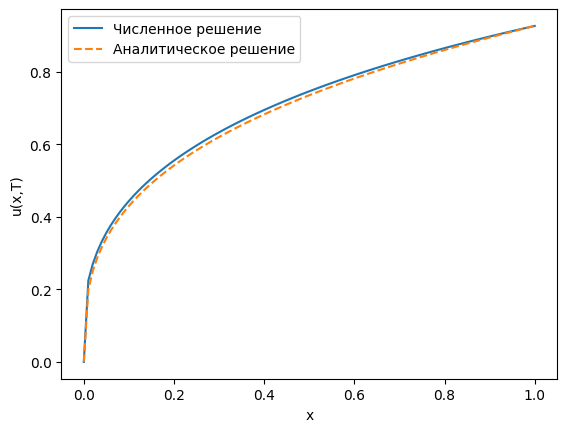

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solve_tridiag_mat(a, b, c, column):
    N = np.size(b)
    p, q = np.zeros(N - 1), np.zeros(N - 1)
    x = np.zeros(N)

    p[0] = -c[0] / b[0]
    q[0] = column[0] / b[0]

    for i in range(1, N - 1):
        p[i] = -c[i] / (a[i - 1] * p[i - 1] + b[i])
        q[i] = (column[i] - a[i - 1] * q[i - 1]) / (a[i - 1] * p[i - 1] + b[i])

    x[N - 1] = (column[N - 1] - a[N - 2] * q[N - 2]) / (a[N - 2] * p[N - 2] + b[N - 1])
    
    for i in range(N - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]
        
    return x

def init_cond(x_grid):
    return x_grid**(1/3)

def bound_cond(t):
    return (0, (1 + t)**(-1/9))  

def build_matrix(a_func, u, L, H, TAU):  
    M = int(L / H)
    b_diag = np.zeros(M + 1)
    a_diag = np.zeros(M + 1)
    c_diag = np.zeros(M + 1)

    for m in range(M + 1):
        if m == 0:
            b_diag[m] = 1 
            c_diag[m] = 0
        elif m == M:
            b_diag[m] = 1 
            a_diag[m] = 0
        else:
            a_func_plus = a_func((u[m+1] + u[m])/2)
            a_func_minus = a_func((u[m] + u[m-1])/2)
            
            a_diag[m] = a_func_minus / H**2
            b_diag[m] = - 1 / TAU - a_func_plus / H**2 - a_func_minus / H**2
            c_diag[m] = a_func_plus / H**2

    a_diag = a_diag[1:] 
    c_diag = c_diag[:-1] 
    
    return (a_diag, b_diag, c_diag)

def a_func(u):
    return u**2

def nonlin_heat_equation_solver(a_func, init_cond, bound_cond, L, H, T, TAU):
    M = int(L / H)
    N = int(T / TAU)
    x_grid = np.linspace(0, L, M + 1)
    
    U = np.zeros((N, M + 1))
    U[0] = init_cond(x_grid)
    
    eps = 1e-6  
    max_iter = 100 
    
    for n in range(N - 1):
        U_prev = U[n].copy()
        a_diag, b_diag, c_diag = build_matrix(a_func, U_prev, L, H, TAU)
        
        rhs = np.zeros(M + 1)
        u_A, u_B = bound_cond((n + 1) * TAU)  
        
        for m in range(M + 1):
            if m == 0:
                rhs[m] = u_A
            elif m == M:
                rhs[m] = u_B
            else:
                rhs[m] = -U[n, m] / TAU  
        
        U[n + 1] = solve_tridiag_mat(a_diag, b_diag, c_diag, rhs)
        
        for j in range(max_iter):
            a_diag, b_diag, c_diag = build_matrix(a_func, U[n + 1], L, H, TAU)
            U_new = solve_tridiag_mat(a_diag, b_diag, c_diag, rhs)
            
            if np.max(np.abs(U_new - U[n + 1])) < eps:
                U[n + 1] = U_new
                break
                
            U[n + 1] = U_new
    
    return U

L = 1
H = 1e-2
M = int(L / H)

T = 1
TAU = 0.5e-4  
N = int(T / TAU)

U = nonlin_heat_equation_solver(a_func, init_cond, bound_cond, L, H, T, TAU)

x_grid = np.linspace(0, L, M + 1)
plt.plot(x_grid, U[-1], label='Численное решение')
plt.plot(x_grid, x_grid**(1/3) * (1 + T)**(-1/9), '--', label='Аналитическое решение')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.legend()
plt.show()